# For existing experiment data, forward propagate the next few projections 

In [31]:
try:
    from mumott.data_handling import DataContainer
except:
    !sh ../scripts/setup.sh

In [32]:
import mumott
print(mumott.__version__)

2.2


In [33]:
from mumott.data_handling import DataContainer
from mumott import Geometry
import copy
from mumott.methods.projectors import SAXSProjectorCUDA, SAXSProjector
import numpy as np
import matplotlib.pyplot as plt
import torch
import lovely_tensors as lt 
lt.monkey_patch()
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget

In [34]:
#load data
dc = DataContainer('/myhome/data/smartt/shared/frogbone/dataset_qbin_0009.h5')
# dc = DataContainer('/das/home/barbaf_l/p20639/Mads/frog/frogbone/dataset_qbin_0009.h5', nonfinite_replacement_value=0.0)

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


In [35]:
#save copy of origial geometry
projections = dc.projections
dc_copy = copy.deepcopy(dc)
geometry_real = dc_copy.geometry
rotations_real = dc_copy.geometry.rotations
joff = dc_copy.geometry.j_offsets
koff = dc_copy.geometry.k_offsets

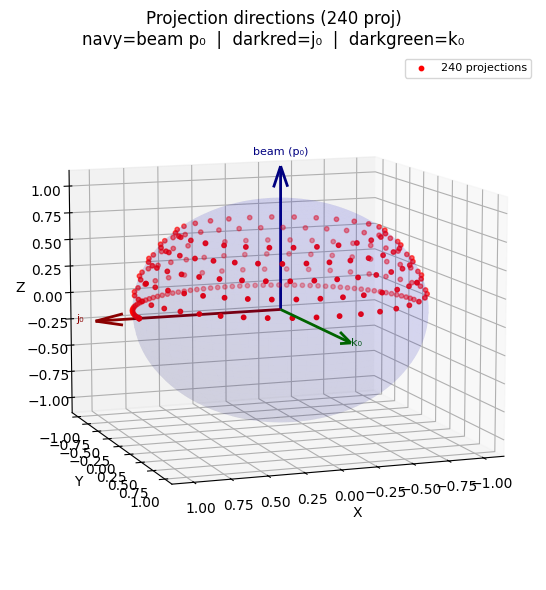

In [36]:
import sys
sys.path.insert(0, '/myhome/smartt')

import importlib
import mumott_al.visualization
importlib.reload(mumott_al.visualization)
from mumott_al.visualization import (
    beam_directions_from_geometry,
    plot_projection_directions,
    plot_projection_directions_comparison,
)

fig, ax = plot_projection_directions(dc.geometry)
plt.show()


# mumott reconstruction

In [37]:
import h5py
from IPython.display import display
# from ipywidgets import interact
from mumott.data_handling import DataContainer
from mumott.output_handling import ProjectionViewer
from mumott.output_handling.saving import dict_to_h5
from mumott.methods.basis_sets import SphericalHarmonics, GaussianKernels
from mumott.methods.projectors import SAXSProjector as SAXSProjector
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

In [38]:
import os

# ── Caching configuration ────────────────────────────────────────────────────
# Set FORCE_RECOMPUTE = True to always run the reconstructions from scratch.
# Set FORCE_RECOMPUTE = False to load cached results when they exist.
FORCE_RECOMPUTE = False

_DATA_PATH = '/myhome/data/smartt/shared/frogbone/dataset_qbin_0009.h5'
CACHE_DIR = os.path.join(os.path.dirname(_DATA_PATH), 'recon_cache')
os.makedirs(CACHE_DIR, exist_ok=True)

print(f"Cache directory : {os.path.abspath(CACHE_DIR)}")
print(f"FORCE_RECOMPUTE : {FORCE_RECOMPUTE}")

Cache directory : /myhome/data/smartt/shared/frogbone/recon_cache
FORCE_RECOMPUTE : False


In [39]:
import torch

_cache_path = os.path.join(CACHE_DIR, 'results.npz')

if not FORCE_RECOMPUTE and os.path.exists(_cache_path):
    print(f"Loading cached 'results' from {_cache_path}")
    results = {k: v for k, v in np.load(_cache_path).items()}
    print("Loaded successfully.")
else:
    print("Computing reconstruction for 'results' ...")
    basis_set = SphericalHarmonics(ell_max=8)
    projector = SAXSProjector(dc.geometry)
    ResidualCalculator = GradientResidualCalculator(
                                    data_container=dc,
                                    basis_set=basis_set,
                                    projector=projector)
    loss_function = SquaredLoss(ResidualCalculator)
    regularizer = Laplacian()
    loss_function.add_regularizer(name='laplacian',
                                  regularizer=regularizer,
                                  regularization_weight=1)
    optimizer = LBFGS(loss_function, maxiter=20)
    results = optimizer.optimize()
    np.savez(_cache_path, **{k: np.asarray(v) for k, v in results.items() if hasattr(v, '__len__')})
    print(f"Results saved to {_cache_path}")

Loading cached 'results' from /myhome/data/smartt/shared/frogbone/recon_cache/results.npz
Loaded successfully.


In [40]:
from mumott_plotting.tomogram_plots import plot_scalar_slices
from ipywidgets import interact
@interact(i=(0, results['x'].shape[0]-1), j=(0, results['x'].shape[1]-1), k=(0, results['x'].shape[2]-1))
def plot_slices(i, j, k):
    fig, axs = plot_scalar_slices(results['x'][..., 0], poi=(i, j, k))
    fig.show()

interactive(children=(IntSlider(value=32, description='i', max=64), IntSlider(value=40, description='j', max=8…

# Synthetic Projection Generation

Using functions from the `mumott_al` library to create new geometries with arbitrary projection directions and generate synthetic projections from a reconstruction.

In [41]:
# Import geometry and projection generation functions from mumott_al library
import sys
sys.path.insert(0, '/myhome/smartt')

from mumott_al import (
    fibonacci_hemisphere,
    cartesian_to_spherical,
    create_geometry_from_directions,
    create_synthetic_projections,
    generate_geometry_and_projections,
    create_synthetic_data_container,
    generate_and_save_synthetic_data,
)

print("Imported mumott_al geometry functions successfully!")
print("Available functions:")
print("- fibonacci_hemisphere(n_points, upper=True)")
print("- cartesian_to_spherical(xyz)")
print("- create_geometry_from_directions(directions, reference_geometry, ...)")
print("- create_synthetic_projections(reconstruction, new_geometry, ...)")
print("- generate_geometry_and_projections(reconstruction, directions, reference_geometry, ...)")
print("- create_synthetic_data_container(geometry, projection_stack, reference_dc, save_path)")
print("- generate_and_save_synthetic_data(reconstruction, directions, reference_dc, ell_max, save_path)")

Imported mumott_al geometry functions successfully!
Available functions:
- fibonacci_hemisphere(n_points, upper=True)
- cartesian_to_spherical(xyz)
- create_geometry_from_directions(directions, reference_geometry, ...)
- create_synthetic_projections(reconstruction, new_geometry, ...)
- generate_geometry_and_projections(reconstruction, directions, reference_geometry, ...)
- create_synthetic_data_container(geometry, projection_stack, reference_dc, save_path)
- generate_and_save_synthetic_data(reconstruction, directions, reference_dc, ell_max, save_path)


## Same geometry with synthetic projections

In [42]:
import importlib
import mumott_al.geometry
importlib.reload(mumott_al.geometry)
from mumott_al.geometry import generate_geometry_and_projections, create_synthetic_data_container

# Create new geometry and synthetic projections using the reconstruction
# directions_copied carries the same inner/outer angles as dc, so we use
# copy_from_reference=True to preserve the exact rotation matrices and
# detector offsets (j/k_offsets) from the original geometry.
directions_copied = torch.stack([torch.tensor(dc.geometry.inner_angles), torch.tensor(dc.geometry.outer_angles)], dim=-1)

same_geometry, synthetic_projection_stack = generate_geometry_and_projections(
    reconstruction=results['x'],
    directions=directions_copied,
    reference_geometry=dc.geometry,
    ell_max=8,
    return_data_container=True,
    copy_from_reference=True,   # ← copy rotations + offsets exactly from dc.geometry
)

# Now create the DataContainer from the geometry and projection stack
synthetic_dc = create_synthetic_data_container(same_geometry, synthetic_projection_stack, dc)

print(f"New geometry created with {len(same_geometry.inner_angles)} projections")
print(f"New DataContainer created with {len(synthetic_dc.projections)} projections")
print(f"Synthetic data shape: {synthetic_dc.data.shape}")
print(f"Reference (original) data shape: {dc.projections.data.shape}")

# Quick sanity check on offsets
import numpy as np
j_diff = np.max(np.abs(np.array(dc.geometry.j_offsets) - np.array(same_geometry.j_offsets)))
k_diff = np.max(np.abs(np.array(dc.geometry.k_offsets) - np.array(same_geometry.k_offsets)))
r_diff = np.max(np.abs(np.array(dc.geometry.rotations)  - np.array(same_geometry.rotations)))
print(f"\nGeometry sanity check:")
print(f"  Max |Δ j_offset| : {j_diff:.2e}  (should be 0)")
print(f"  Max |Δ k_offset| : {k_diff:.2e}  (should be 0)")
print(f"  Max |Δ rotation| : {r_diff:.2e}  (should be 0)")


New geometry created with 240 projections
New DataContainer created with 240 projections
Synthetic data shape: (240, 73, 100, 8)
Reference (original) data shape: (240, 73, 100, 8)

Geometry sanity check:
  Max |Δ j_offset| : 0.00e+00  (should be 0)
  Max |Δ k_offset| : 0.00e+00  (should be 0)
  Max |Δ rotation| : 0.00e+00  (should be 0)


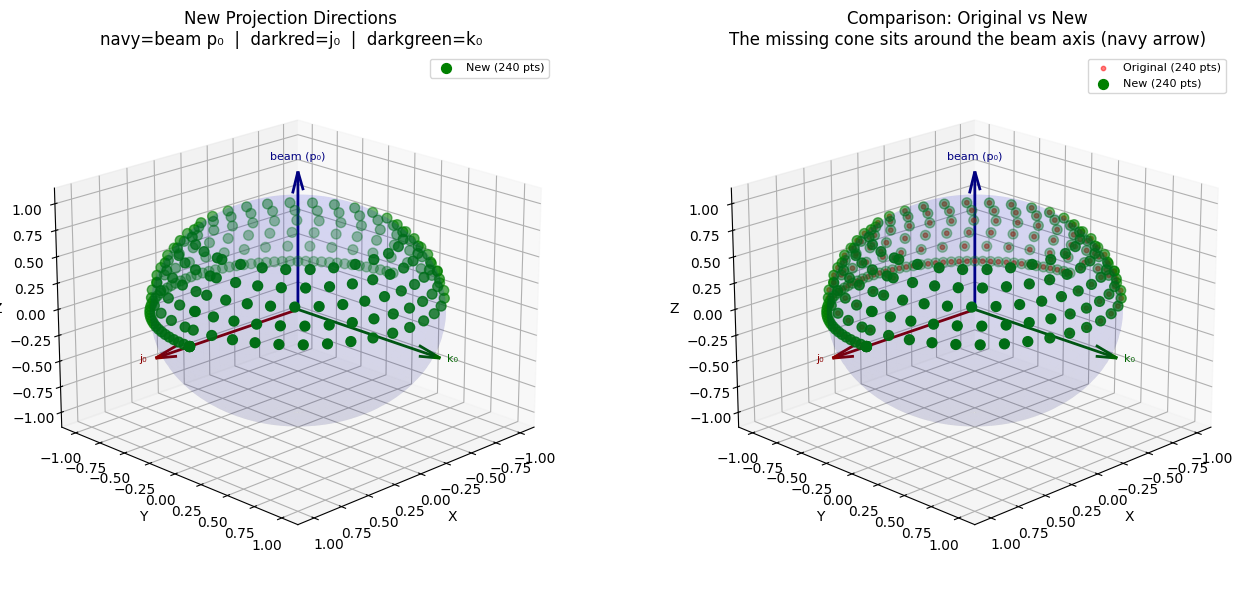

In [43]:
fig, (ax1, ax2) = plot_projection_directions_comparison(
    reference_geometry=dc.geometry,
    new_directions=synthetic_dc.geometry,
)
plt.show()

In [44]:
import torch

_cache_path = os.path.join(CACHE_DIR, 'results_synthetic.npz')

if not FORCE_RECOMPUTE and os.path.exists(_cache_path):
    print(f"Loading cached 'results_synthetic' from {_cache_path}")
    results_synthetic = {k: v for k, v in np.load(_cache_path).items()}
    print("Loaded successfully.")
else:
    print("Computing reconstruction for 'results_synthetic' ...")
    basis_set = SphericalHarmonics(ell_max=8)
    projector_new = SAXSProjector(synthetic_dc.geometry)
    ResidualCalculator = GradientResidualCalculator(
                                    data_container=synthetic_dc,
                                    basis_set=basis_set,
                                    projector=projector_new)
    loss_function = SquaredLoss(ResidualCalculator)
    regularizer = Laplacian()
    loss_function.add_regularizer(name='laplacian',
                                  regularizer=regularizer,
                                  regularization_weight=1)
    optimizer = LBFGS(loss_function, maxiter=20)
    results_synthetic = optimizer.optimize()
    np.savez(_cache_path, **{k: np.asarray(v) for k, v in results_synthetic.items() if hasattr(v, '__len__')})
    print(f"Results saved to {_cache_path}")

Computing reconstruction for 'results_synthetic' ...
 75%|███████▌  | 15/20 [06:00<02:00, 24.01s/it]
Results saved to /myhome/data/smartt/shared/frogbone/recon_cache/results_synthetic.npz


In [45]:
from mumott_plotting.tomogram_plots import plot_scalar_slices
from ipywidgets import interact
@interact(i=(0, results_synthetic['x'].shape[0]-1), j=(0, results_synthetic['x'].shape[1]-1), k=(0, results_synthetic['x'].shape[2]-1))
def plot_slices(i, j, k):
    fig, axs = plot_scalar_slices(results_synthetic['x'][..., 0], poi=(i, j, k))
    fig.show()

interactive(children=(IntSlider(value=32, description='i', max=64), IntSlider(value=40, description='j', max=8…

## Test: Generate k evenly sampled projections on the top hemisphere

In [72]:
# Generate k evenly sampled points on the top hemisphere
n_new_projections = 240
new_directions = fibonacci_hemisphere(n_new_projections, upper=True, missing_wedge_angle=45)

print(f"Generated {len(new_directions)} directions on the upper hemisphere")
print(f"Direction shape: {new_directions.shape}")
print(f"\nFirst 5 directions (x, y, z):")
print(new_directions[:5])

# Convert to spherical coordinates for verification
inner_angles_new, outer_angles_new = cartesian_to_spherical(new_directions)
print(f"\nFirst 5 directions as (inner_angle, outer_angle) in degrees:")
for i in range(5):
    print(f"  [{np.degrees(inner_angles_new[i]):7.2f}°, {np.degrees(outer_angles_new[i]):7.2f}°]")

Generated 240 directions on the upper hemisphere
Direction shape: (240, 3)

First 5 directions (x, y, z):
[[ 1.          0.          0.        ]
 [-0.73736565  0.67548734  0.00295861]
 [ 0.08742419 -0.9961536   0.00591721]
 [ 0.60841489  0.79356949  0.00887582]
 [-0.98464453 -0.17416975  0.01183442]]

First 5 directions as (inner_angle, outer_angle) in degrees:
  [   0.00°,   90.00°]
  [ 137.51°,   89.83°]
  [ -84.98°,   89.66°]
  [  52.52°,   89.49°]
  [-169.97°,   89.32°]


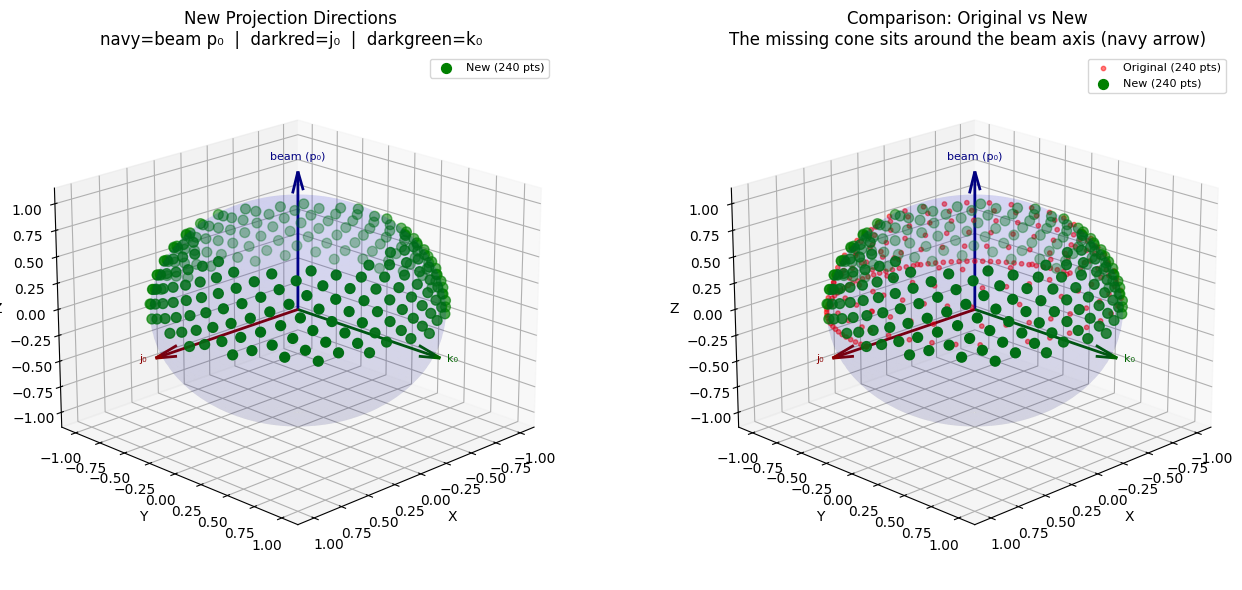

In [73]:
fig, (ax1, ax2) = plot_projection_directions_comparison(
    reference_geometry=dc.geometry,
    new_directions=new_directions,
)
plt.show()


# New geometry with fibonacci sample

In [74]:
# Create new geometry and synthetic projections using the reconstruction
# Note: This requires 'results' from the mumott reconstruction to be available
# If you haven't run the reconstruction, run the cells above first

# Create new geometry with k hemisphere points
# IMPORTANT: Use return_data_container=True to get a ProjectionStack instead of numpy array
new_geometry, synthetic_projection_stack = generate_geometry_and_projections(
    reconstruction=results['x'],
    directions=new_directions,
    reference_geometry=dc.geometry,
    ell_max=8,
    return_data_container=True,  # Changed to True to get ProjectionStack
)

# Now create the DataContainer from the geometry and projection stack
new_dc = create_synthetic_data_container(new_geometry, synthetic_projection_stack, dc)

print(f"New geometry created with {len(new_geometry.inner_angles)} projections")
print(f"New DataContainer created with {len(new_dc.projections)} projections")
print(f"Synthetic data shape: {new_dc.data.shape}")
print(f"Reference (original) data shape: {dc.projections.data.shape}")

New geometry created with 240 projections
New DataContainer created with 240 projections
Synthetic data shape: (240, 73, 100, 8)
Reference (original) data shape: (240, 73, 100, 8)


In [75]:
projector = SAXSProjector(new_dc.geometry)
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=new_dc.geometry.probed_coordinates) 
forward_projections = basis_set.forward(projector.forward(results['x'].astype(np.float64)))
forward_projections.shape

(240, 73, 100, 8)

In [ ]:
import torch

# FORCE_RECOMPUTE = True
_cache_path = os.path.join(CACHE_DIR, 'results_new.npz')

if not FORCE_RECOMPUTE and os.path.exists(_cache_path):
    print(f"Loading cached 'results_new' from {_cache_path}")
    results_new = {k: v for k, v in np.load(_cache_path).items()}
    print("Loaded successfully.")
else:
    print("Computing reconstruction for 'results_new' ...")
    basis_set = SphericalHarmonics(ell_max=8)
    projector_new = SAXSProjector(new_dc.geometry)
    ResidualCalculator = GradientResidualCalculator(
                                    data_container=new_dc,
                                    basis_set=basis_set,
                                    projector=projector_new)
    loss_function = SquaredLoss(ResidualCalculator)
    regularizer = Laplacian()
    loss_function.add_regularizer(name='laplacian',
                                  regularizer=regularizer,
                                  regularization_weight=1)
    optimizer = LBFGS(loss_function, maxiter=20)
    results_new = optimizer.optimize()
    np.savez(_cache_path, **{k: np.asarray(v) for k, v in results_new.items() if hasattr(v, '__len__')})
    print(f"Results saved to {_cache_path}")

Computing reconstruction for 'results_new' ...
  0%|          | 0/20 [00:00<?, ?it/s]

In [77]:
from mumott_plotting.tomogram_plots import plot_scalar_slices
from ipywidgets import interact
@interact(i=(0, results_new['x'].shape[0]-1), j=(0, results_new['x'].shape[1]-1), k=(0, results_new['x'].shape[2]-1))
def plot_slices(i, j, k):
    fig, axs = plot_scalar_slices(results_new['x'][..., 0], poi=(i, j, k))
    fig.show()

interactive(children=(IntSlider(value=32, description='i', max=64), IntSlider(value=40, description='j', max=8…

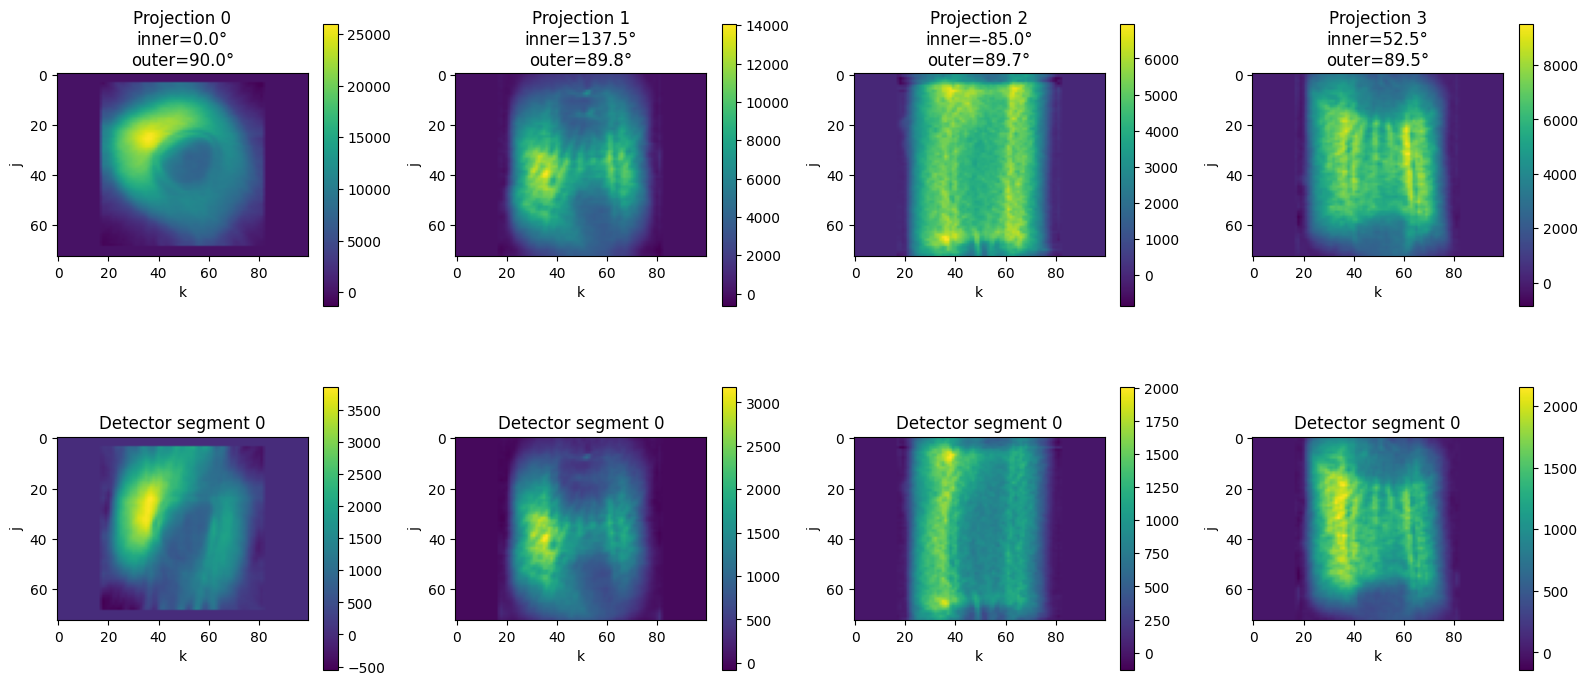

Projection data statistics:
  Min: -4579.0922
  Max: 13800.8010
  Mean: 381.3525


In [78]:
synthetic_projections = forward_projections

# Visualize a few synthetic projections
n_show = min(4, len(synthetic_projections))
fig, axes = plt.subplots(2, n_show, figsize=(4 * n_show, 8))

for i in range(n_show):
    # Show sum over detector segments (integrated signal)
    ax_top = axes[0, i]
    im = ax_top.imshow(synthetic_projections[i].sum(axis=-1), cmap='viridis')
    ax_top.set_title(f'Projection {i}\ninner={np.degrees(new_geometry.inner_angles[i]):.1f}°\nouter={np.degrees(new_geometry.outer_angles[i]):.1f}°')
    ax_top.set_xlabel('k')
    ax_top.set_ylabel('j')
    plt.colorbar(im, ax=ax_top, shrink=0.7)
    
    # Show first detector segment
    ax_bottom = axes[1, i]
    im = ax_bottom.imshow(synthetic_projections[i, :, :, 0], cmap='viridis')
    ax_bottom.set_title(f'Detector segment 0')
    ax_bottom.set_xlabel('k')
    ax_bottom.set_ylabel('j')
    plt.colorbar(im, ax=ax_bottom, shrink=0.7)

plt.tight_layout()
plt.show()

print(f"Projection data statistics:")
print(f"  Min: {synthetic_projections.min():.4f}")
print(f"  Max: {synthetic_projections.max():.4f}")
print(f"  Mean: {synthetic_projections.mean():.4f}")

## Create a full DataContainer with synthetic projections

In [53]:
# Create a complete DataContainer-like structure with the synthetic projections
# This creates a ProjectionStack that can be used similar to dc.projections

new_geometry_full, synthetic_projection_stack = generate_geometry_and_projections(
    reconstruction=results['x'],
    directions=new_directions,
    reference_geometry=dc.geometry,
    ell_max=8,
    return_data_container=True,  # Return ProjectionStack instead of array
)

print(f"Created ProjectionStack with {len(synthetic_projection_stack)} projections")
print(f"Data shape: {synthetic_projection_stack.data.shape}")
print(f"Geometry inner angles: {len(synthetic_projection_stack.geometry.inner_angles)} projections")
print(f"\nThis ProjectionStack can be used like dc.projections for further processing.")

Created ProjectionStack with 20 projections
Data shape: (20, 73, 100, 8)
Geometry inner angles: 20 projections

This ProjectionStack can be used like dc.projections for further processing.


# Reconstruction Comparison Metrics

Compare reconstructions using the metrics from `mumott_al`:
- **Coefficient-based**: MSE and normalized MSE of spherical harmonic coefficients
- **Projection-based**: MSE, PSNR, SSIM per detector channel and globally
- **Orientation-based**: Cosine similarity of principal directions (eigenvector_1)

In [54]:
# Import metrics from mumott_al
from mumott_al import (
    mse_coefficients,
    normalized_mse_coefficients,
    projection_metrics,
    orientation_similarity,
    compare_reconstructions,
)
from mumott_al.metrics import print_comparison_results

print("Imported mumott_al metrics functions successfully!")

Imported mumott_al metrics functions successfully!


In [55]:
import importlib
import mumott_al.metrics
importlib.reload(mumott_al.metrics)
from mumott_al.metrics import compare_reconstructions, print_comparison_results, real_space_metrics, RealSpaceMetricsResult

In [70]:
# Compare results['x'] (full data reconstruction) with results_new['x'] (sparse hemisphere reconstruction)
# Note: results_new was reconstructed from only 20 synthetic hemisphere projections

print("Comparing reconstructions:")
print(f"  - results['x']: Reconstruction from full original data ({len(dc.geometry.inner_angles)} projections)")
print(f"  - results_synthetic['x']: Reconstruction from synthetic hemisphere data ({len(new_dc.geometry.inner_angles)} projections)")
print(f"  - Both have shape: {results['x'].shape}")

# Run comprehensive comparison.
# weights must match the geometry used for projection, so use new_dc.projections.weights (20 projections).
# dc.projections.weights has 240 projections and cannot be used with new_dc.geometry.
comparison = compare_reconstructions(
    reconstruction_pred=results_synthetic['x'],
    reconstruction_gt=results['x'],
    geometry=dc.geometry,  # Use dc geometry for projection comparison
    ell_max=8,
    mask=None,  # Could add a mask to focus on sample region
    weights=dc.projections.weights,  # weights must match geometry (20 projections)
    compute_projection_metrics=True,
    compute_orientation_metrics=True,
    compute_real_space_metrics=True,
    real_space_resolution_in_degrees=10,  # ~370 dirs; fast with vectorized SSIM
    percentile_low=5.0,
    percentile_high=95.0,
    verbose=True,
)

# Print results
print_comparison_results(comparison)


Comparing reconstructions:
  - results['x']: Reconstruction from full original data (240 projections)
  - results_synthetic['x']: Reconstruction from synthetic hemisphere data (20 projections)
  - Both have shape: (65, 82, 65, 45)
[1/4] Coefficient-based metrics ...
      MSE=4.1521e-01  MAE=3.2495e-01  norm-MSE=1.7157e-01
[2/4] Projection-based metrics  (240 projections) ...
  [projection] Forward projecting pred (240 projections) ...
  [projection] Forward projecting gt  (240 projections) ...
  [projection] Computing per-channel metrics (8 channels × 240 projections) ...


  channels:   0%|          | 0/8 [00:00<?, ?it/s]

      PSNR=34.74 dB  SSIM=0.9578
[3/4] Orientation-based metrics ...
      cosine_sim=0.9772  angular_err=6.88°
[4/4] Real-space SH metrics  (resolution=10°) ...
  [real_space] Building SH evaluation matrix (10° grid) ...
  [real_space] Evaluating SH functions on 370 directions for 346450 voxels ...


  SSIM z-slices:   0%|          | 0/65 [00:00<?, ?it/s]

      PSNR=18.86 dB  SSIM=0.8048
RECONSTRUCTION COMPARISON RESULTS

--- Coefficient-based Metrics ---
  MSE (raw):        4.152118e-01
  MAE (raw):        3.249523e-01
  MSE (normalized): 1.715657e-01

--- Projection-based Metrics (8 channels) ---
  Global MSE:  4.646841e+02
  Global MAE:  1.074400e+01
  Global PSNR: 34.74 dB
  Global SSIM: 0.9578

  Per-channel MAE:  [12.4768  9.3468  8.9924 11.8719 11.8793  9.0045  9.4919 12.8884]
  Per-channel PSNR: [25.25 30.71 36.1  38.98 39.1  36.12 30.62 23.92] dB
  Per-channel SSIM: [0.9369 0.9492 0.9665 0.9804 0.9806 0.9666 0.9474 0.9353]

--- Orientation-based Metrics ---
  Valid voxels:              300055
  Cosine similarity (mean):  0.9772
  Cosine similarity (std):   0.0877
  Angular error (mean):      6.88°
  Angular error (std):       10.66°

--- Real-Space SH Function Metrics ---
  Grid resolution:  10°  (370 directions)
  MSE:              1.881881e+01
  MAE:              2.350345e+00
  PSNR:             18.86 dB
  SSIM:             0

In [79]:
# Compare results['x'] (full data reconstruction) with results_new['x'] (sparse hemisphere reconstruction)
# Note: results_new was reconstructed from only 20 synthetic hemisphere projections

print("Comparing reconstructions:")
print(f"  - results['x']: Reconstruction from full original data ({len(dc.geometry.inner_angles)} projections)")
print(f"  - results_new['x']: Reconstruction from synthetic hemisphere data ({len(new_dc.geometry.inner_angles)} projections)")
print(f"  - Both have shape: {results['x'].shape}")

# Run comprehensive comparison.
# weights must match the geometry used for projection, so use new_dc.projections.weights (20 projections).
# dc.projections.weights has 240 projections and cannot be used with new_dc.geometry.
comparison = compare_reconstructions(
    reconstruction_pred=results_new['x'],
    reconstruction_gt=results['x'],
    geometry=dc.geometry,  # Use dc geometry for projection comparison
    ell_max=8,
    mask=None,  # Could add a mask to focus on sample region
    weights=dc.projections.weights,  # weights must match geometry (20 projections)
    compute_projection_metrics=True,
    compute_orientation_metrics=True,
    compute_real_space_metrics=True,
    real_space_resolution_in_degrees=10,  # ~370 dirs; fast with vectorized SSIM
    percentile_low=5.0,
    percentile_high=95.0,
    verbose=True,
)

# Print results
print_comparison_results(comparison)


Comparing reconstructions:
  - results['x']: Reconstruction from full original data (240 projections)
  - results_new['x']: Reconstruction from synthetic hemisphere data (240 projections)
  - Both have shape: (65, 82, 65, 45)
[1/4] Coefficient-based metrics ...
      MSE=2.4070e+00  MAE=7.6903e-01  norm-MSE=8.5085e-01
[2/4] Projection-based metrics  (240 projections) ...
  [projection] Forward projecting pred (240 projections) ...
  [projection] Forward projecting gt  (240 projections) ...
  [projection] Computing per-channel metrics (8 channels × 240 projections) ...


  channels:   0%|          | 0/8 [00:00<?, ?it/s]

      PSNR=16.54 dB  SSIM=0.5967
[3/4] Orientation-based metrics ...
      cosine_sim=0.8648  angular_err=21.62°
[4/4] Real-space SH metrics  (resolution=10°) ...
  [real_space] Building SH evaluation matrix (10° grid) ...
  [real_space] Evaluating SH functions on 370 directions for 346450 voxels ...


  SSIM z-slices:   0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 

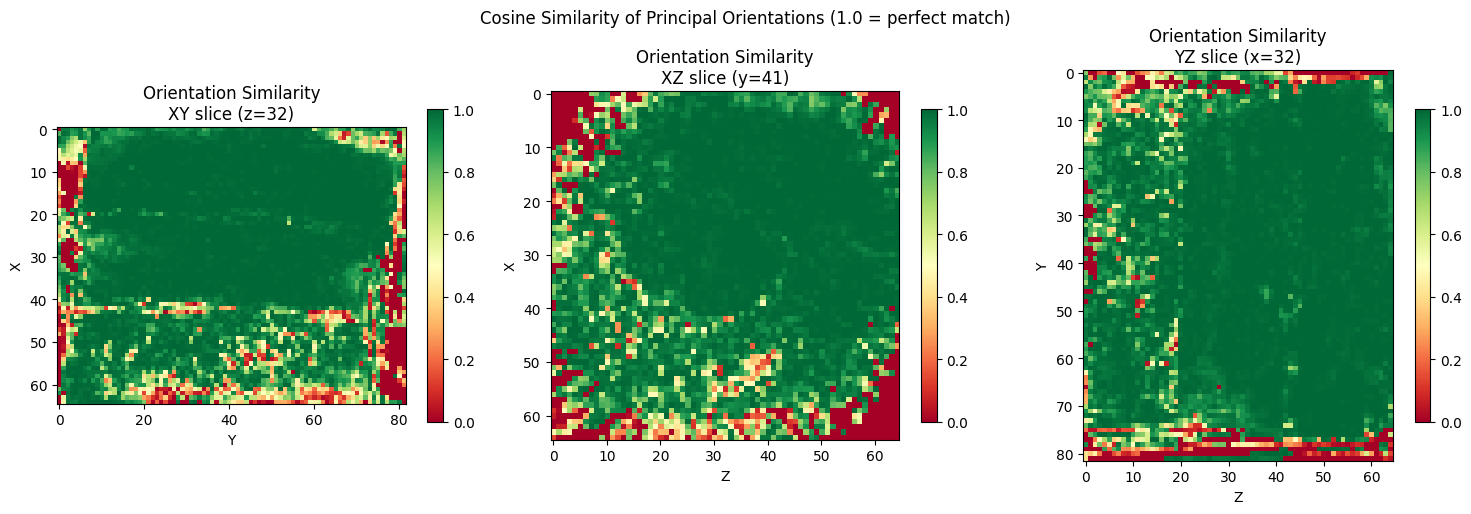

In [58]:
# Visualize orientation similarity map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Get middle slices
mid_x = results['x'].shape[0] // 2
mid_y = results['x'].shape[1] // 2
mid_z = results['x'].shape[2] // 2

cosine_map = comparison.orientation_metrics.cosine_similarity_map

# XY slice (middle z)
im0 = axes[0].imshow(cosine_map[:, :, mid_z], cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_title(f'Orientation Similarity\nXY slice (z={mid_z})')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('X')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# XZ slice (middle y)
im1 = axes[1].imshow(cosine_map[:, mid_y, :], cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title(f'Orientation Similarity\nXZ slice (y={mid_y})')
axes[1].set_xlabel('Z')
axes[1].set_ylabel('X')
plt.colorbar(im1, ax=axes[1], shrink=0.8)

# YZ slice (middle x)
im2 = axes[2].imshow(cosine_map[mid_x, :, :], cmap='RdYlGn', vmin=0, vmax=1)
axes[2].set_title(f'Orientation Similarity\nYZ slice (x={mid_x})')
axes[2].set_xlabel('Z')
axes[2].set_ylabel('Y')
plt.colorbar(im2, ax=axes[2], shrink=0.8)

plt.suptitle('Cosine Similarity of Principal Orientations (1.0 = perfect match)', fontsize=12)
plt.tight_layout()
plt.show()

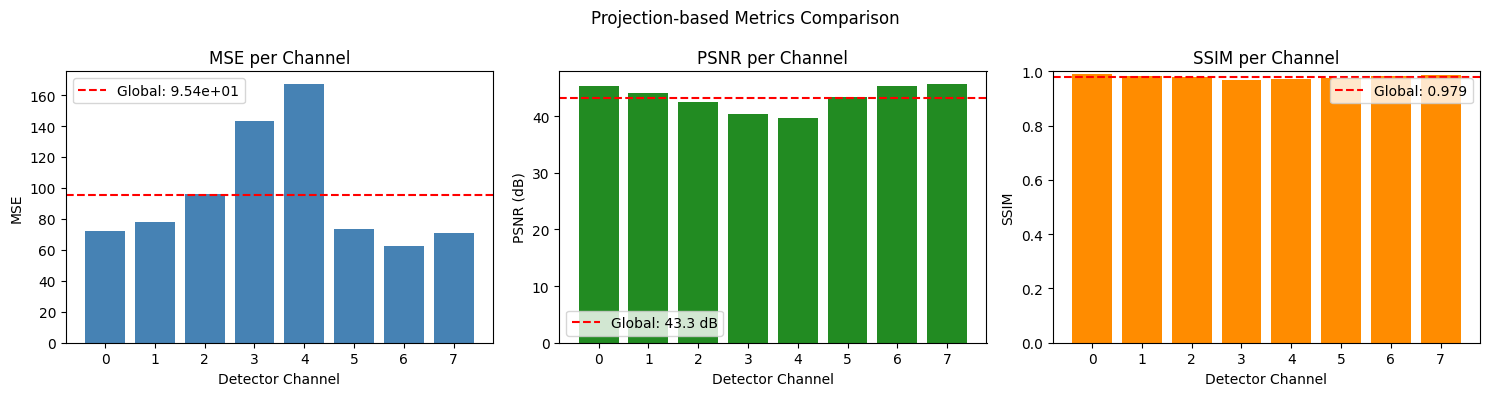

In [59]:
# Visualize projection metrics per channel
pm = comparison.projection_metrics

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

channels = np.arange(pm.n_channels)

# MSE per channel
axes[0].bar(channels, pm.mse_per_channel, color='steelblue')
axes[0].axhline(pm.mse_global, color='red', linestyle='--', label=f'Global: {pm.mse_global:.2e}')
axes[0].set_xlabel('Detector Channel')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE per Channel')
axes[0].legend()

# PSNR per channel
axes[1].bar(channels, pm.psnr_per_channel, color='forestgreen')
axes[1].axhline(pm.psnr_global, color='red', linestyle='--', label=f'Global: {pm.psnr_global:.1f} dB')
axes[1].set_xlabel('Detector Channel')
axes[1].set_ylabel('PSNR (dB)')
axes[1].set_title('PSNR per Channel')
axes[1].legend()

# SSIM per channel
axes[2].bar(channels, pm.ssim_per_channel, color='darkorange')
axes[2].axhline(pm.ssim_global, color='red', linestyle='--', label=f'Global: {pm.ssim_global:.3f}')
axes[2].set_xlabel('Detector Channel')
axes[2].set_ylabel('SSIM')
axes[2].set_title('SSIM per Channel')
axes[2].set_ylim(0, 1)
axes[2].legend()

plt.suptitle('Projection-based Metrics Comparison', fontsize=12)
plt.tight_layout()
plt.show()

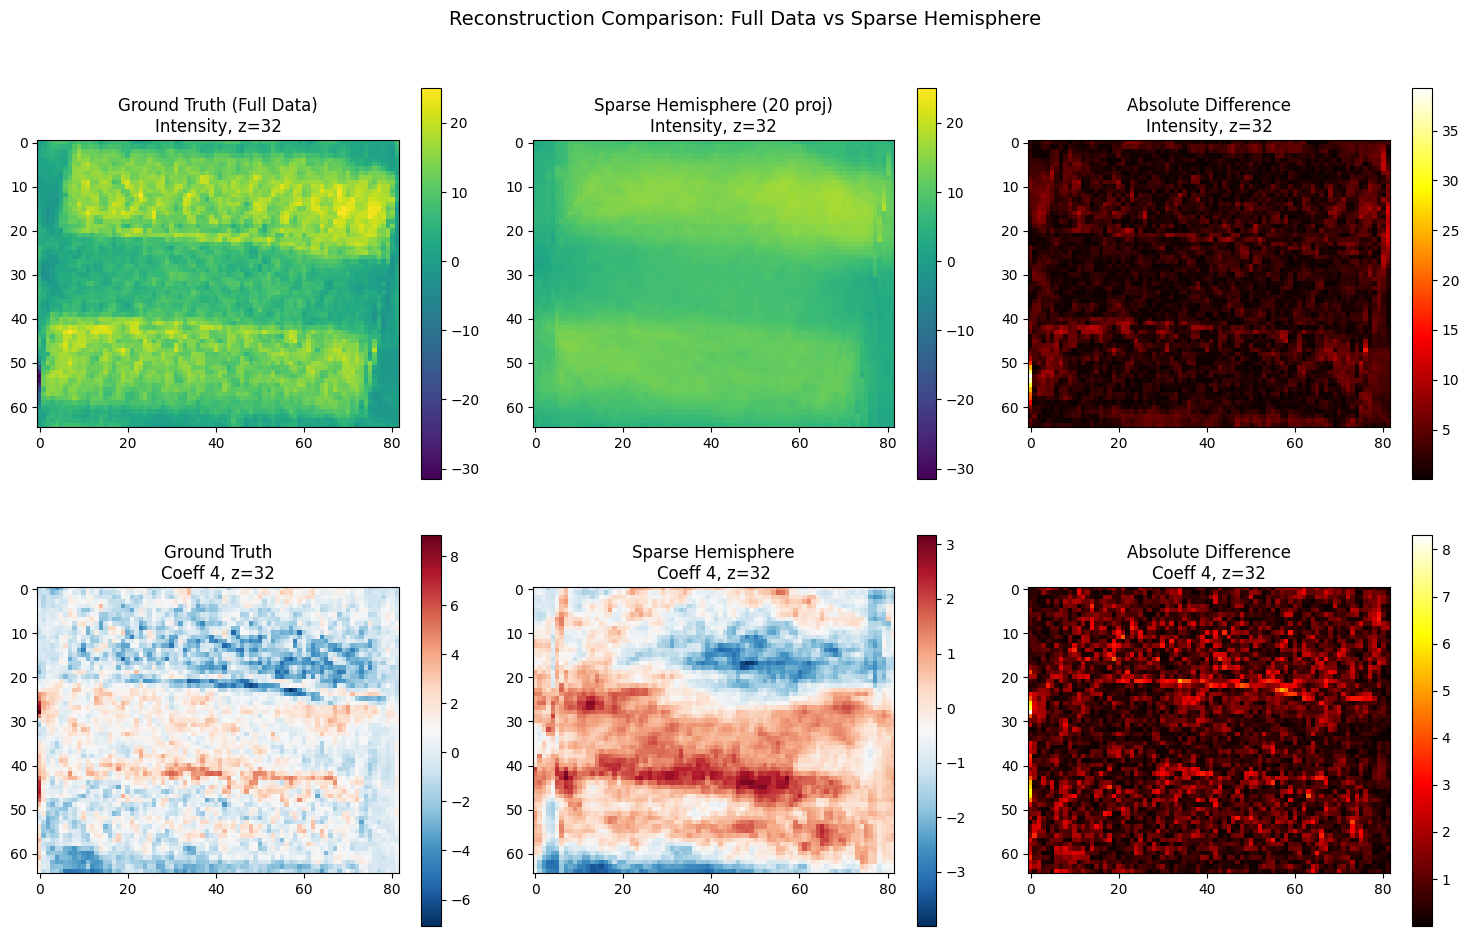

In [60]:
# Side-by-side comparison of reconstructions (first coefficient - intensity)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

mid_z = results['x'].shape[2] // 2

# Ground truth (full data)
vmin = results['x'][:, :, mid_z, 0].min()
vmax = results['x'][:, :, mid_z, 0].max()
im00 = axes[0, 0].imshow(results['x'][:, :, mid_z, 0], cmap='viridis')
axes[0, 0].set_title(f'Ground Truth (Full Data)\nIntensity, z={mid_z}')
plt.colorbar(im00, ax=axes[0, 0], shrink=0.8)

im01 = axes[0, 1].imshow(results_new['x'][:, :, mid_z, 0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[0, 1].set_title(f'Sparse Hemisphere (20 proj)\nIntensity, z={mid_z}')
plt.colorbar(im01, ax=axes[0, 1], shrink=0.8)

diff_intensity = np.abs(results['x'][:, :, mid_z, 0] - results_new['x'][:, :, mid_z, 0])
im02 = axes[0, 2].imshow(diff_intensity, cmap='hot')
axes[0, 2].set_title(f'Absolute Difference\nIntensity, z={mid_z}')
plt.colorbar(im02, ax=axes[0, 2], shrink=0.8)

# Second coefficient (anisotropy-related)
coeff_idx = 4  # Pick a higher-order coefficient
im10 = axes[1, 0].imshow(results['x'][:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[1, 0].set_title(f'Ground Truth\nCoeff {coeff_idx}, z={mid_z}')
plt.colorbar(im10, ax=axes[1, 0], shrink=0.8)

im11 = axes[1, 1].imshow(results_new['x'][:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[1, 1].set_title(f'Sparse Hemisphere\nCoeff {coeff_idx}, z={mid_z}')
plt.colorbar(im11, ax=axes[1, 1], shrink=0.8)

diff_coeff = np.abs(results['x'][:, :, mid_z, coeff_idx] - results_new['x'][:, :, mid_z, coeff_idx])
im12 = axes[1, 2].imshow(diff_coeff, cmap='hot')
axes[1, 2].set_title(f'Absolute Difference\nCoeff {coeff_idx}, z={mid_z}')
plt.colorbar(im12, ax=axes[1, 2], shrink=0.8)

plt.suptitle('Reconstruction Comparison: Full Data vs Sparse Hemisphere', fontsize=14)
plt.tight_layout()
plt.show()

## Projection residuals: predicted vs measured

Forward-project each reconstruction through the geometry of `dc` and compare the predictions against the measured projections stored in `dc`.  
Both **MSE** and **MAE** are shown per projection angle and per detector channel.

In [61]:
import importlib
import mumott_al.visualization
importlib.reload(mumott_al.visualization)
from mumott_al.visualization import plot_projection_residuals, plot_projection_residuals_comparison

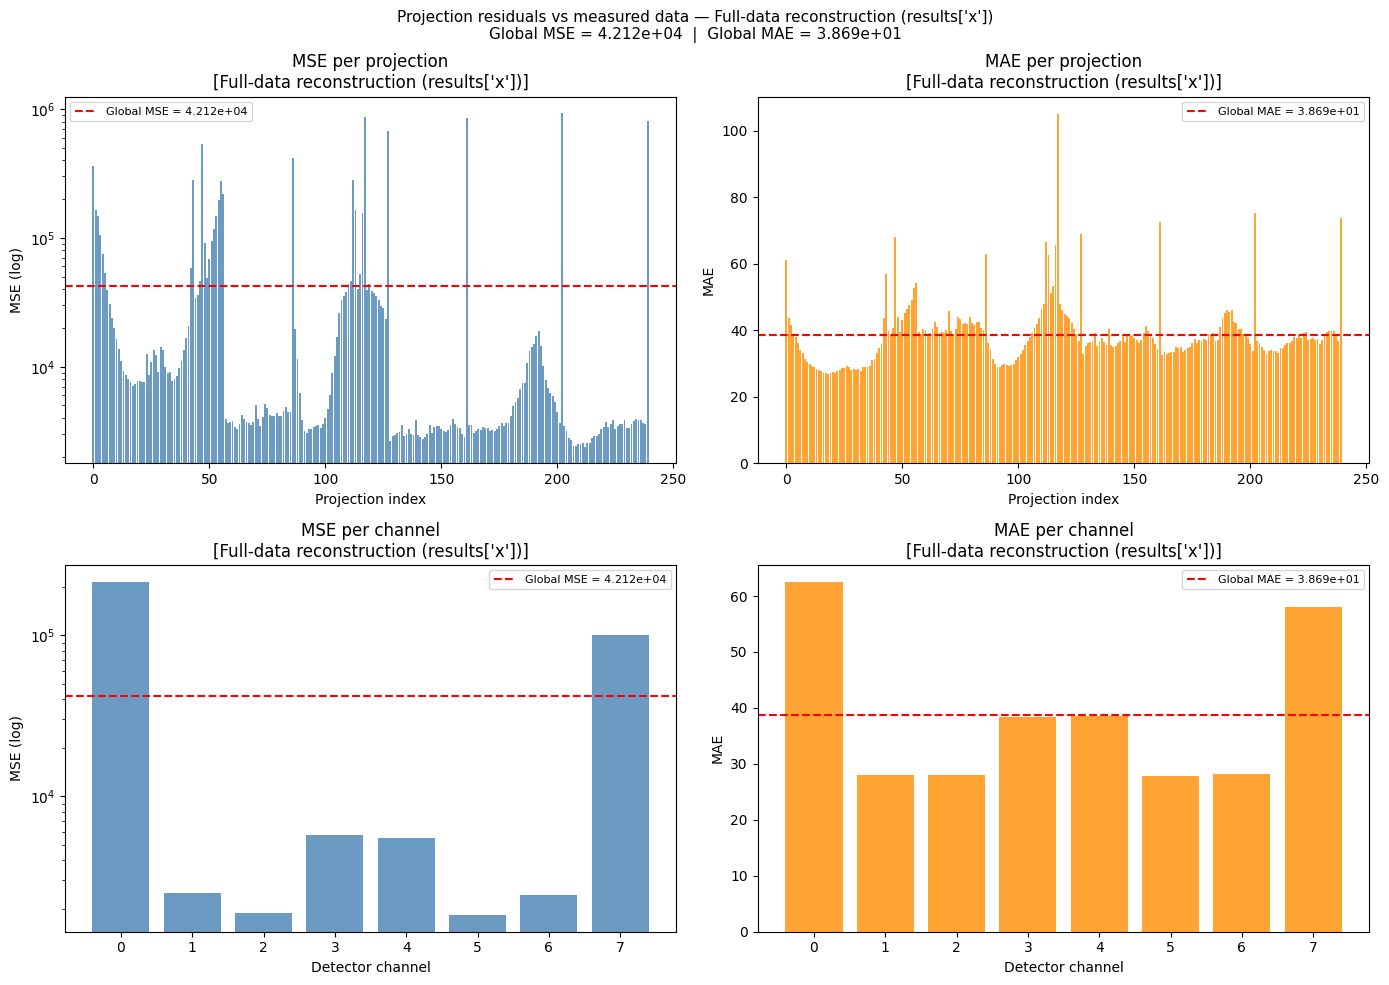

Global MSE: 4.2118e+04
Global MAE: 3.8686e+01


In [62]:
# Projection residuals for results['x'] (full-data reconstruction) vs dc
fig1, axes1, stats1 = plot_projection_residuals(
    reconstruction=results['x'],
    data_container=dc,
    ell_max=8,
    label="Full-data reconstruction (results['x'])",
    log_scale_mse=True,
)
plt.show()

print(f"Global MSE: {stats1['global_mse']:.4e}")
print(f"Global MAE: {stats1['global_mae']:.4e}")

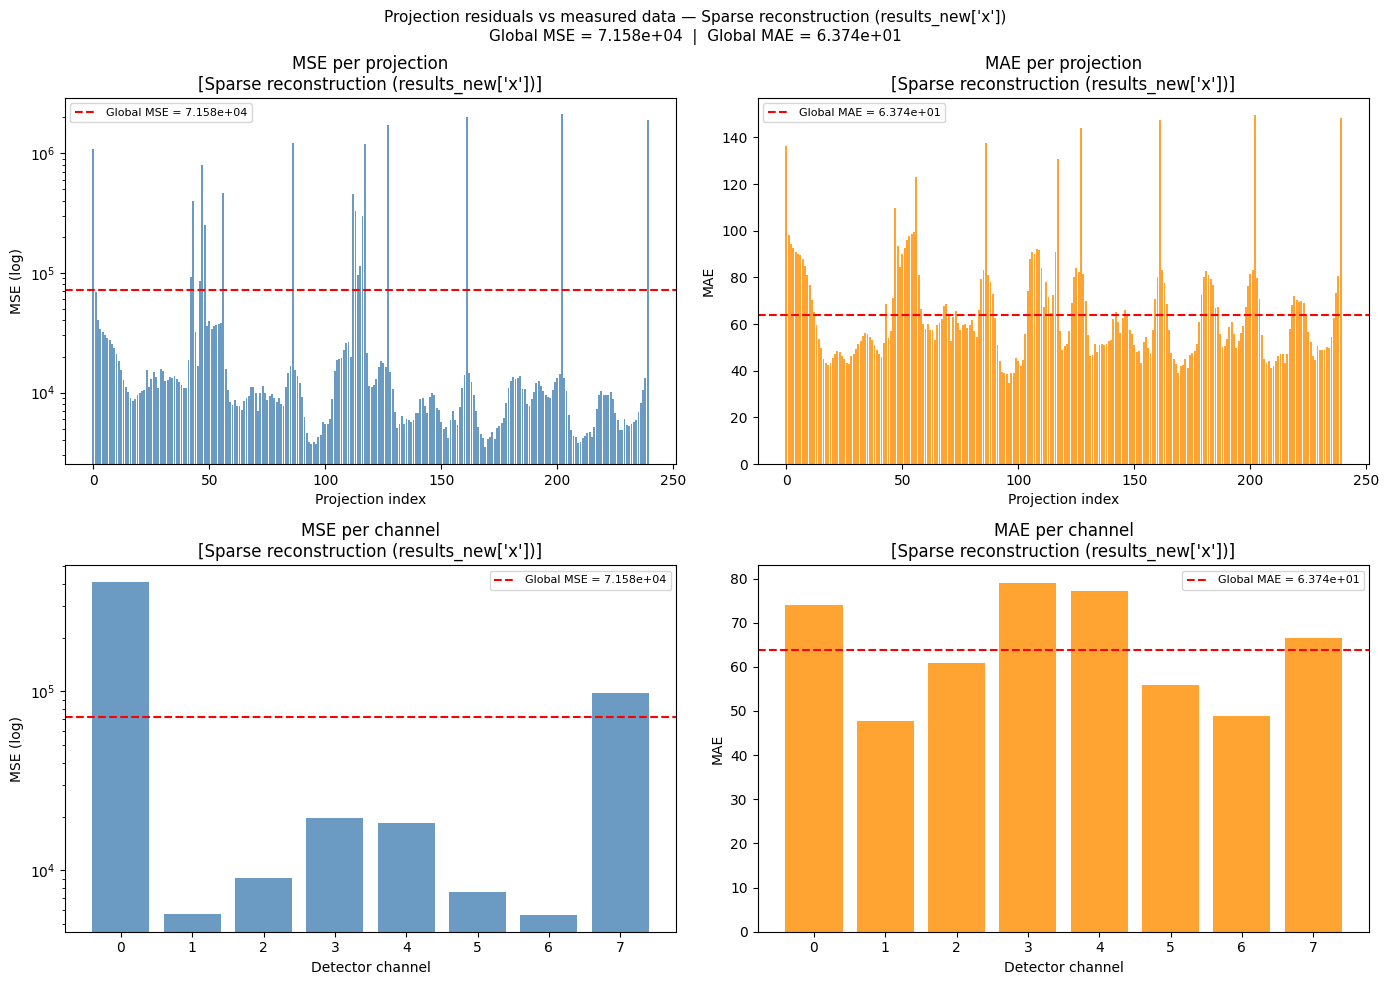

Global MSE: 7.1578e+04
Global MAE: 6.3739e+01


In [63]:
# Projection residuals for results_new['x'] (sparse-hemisphere reconstruction) vs dc
fig2, axes2, stats2 = plot_projection_residuals(
    reconstruction=results_new['x'],
    data_container=dc,
    ell_max=8,
    label="Sparse reconstruction (results_new['x'])",
    log_scale_mse=True,
)
plt.show()

print(f"Global MSE: {stats2['global_mse']:.4e}")
print(f"Global MAE: {stats2['global_mae']:.4e}")

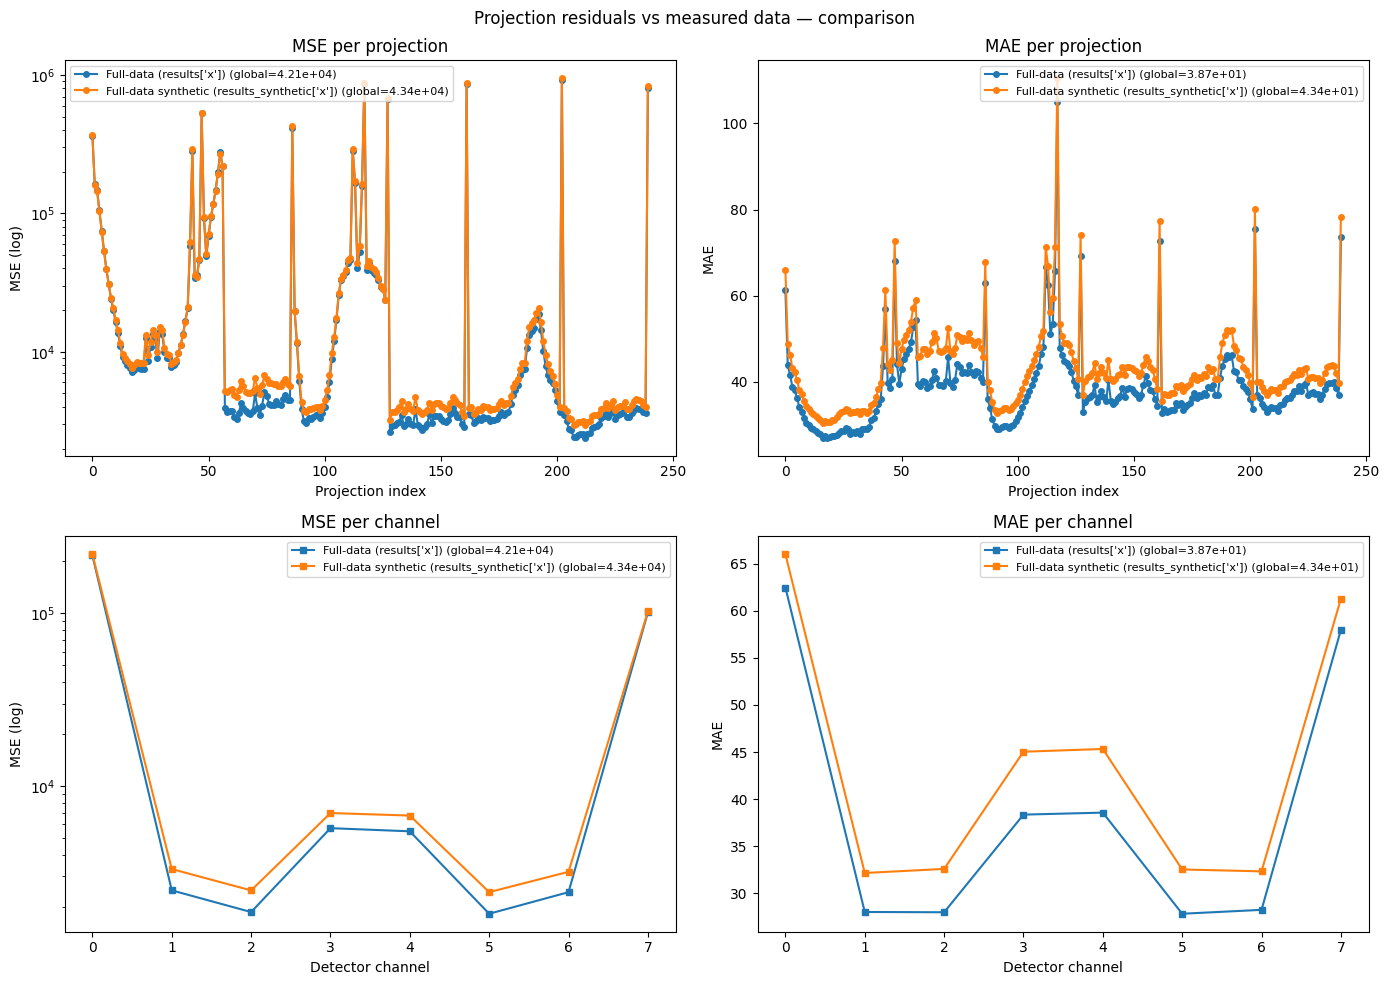

Reconstruction                             Global MSE   Global MAE
------------------------------------------------------------------
Full-data (results['x'])                   4.2118e+04   3.8686e+01
Full-data synthetic (results_synthetic['x'])   4.3384e+04   4.3407e+01


In [64]:
# Side-by-side comparison: both reconstructions on shared axes
fig3, axes3, all_stats = plot_projection_residuals_comparison(
    reconstructions={
        "Full-data (results['x'])": results['x'],
        "Full-data synthetic (results_synthetic['x'])": results_synthetic['x'],
    },
    data_container=dc,
    ell_max=8,
    log_scale_mse=True,
)
plt.show()

# Print summary table
print(f"{'Reconstruction':<40} {'Global MSE':>12} {'Global MAE':>12}")
print("-" * 66)
for lbl, st in all_stats.items():
    print(f"{lbl:<40} {st['global_mse']:>12.4e} {st['global_mae']:>12.4e}")

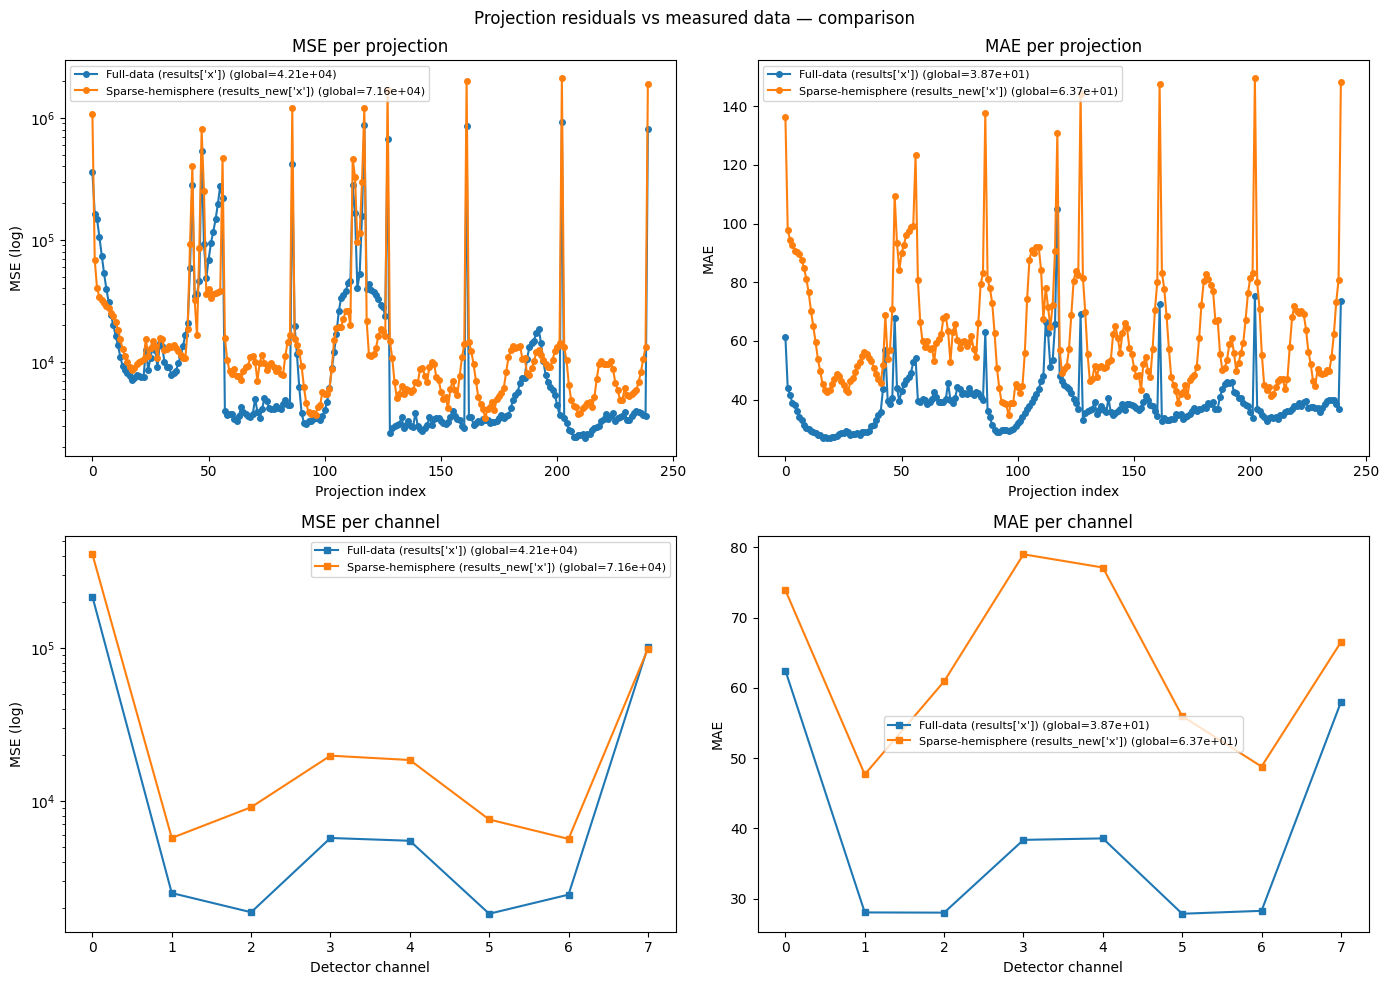

Reconstruction                             Global MSE   Global MAE
------------------------------------------------------------------
Full-data (results['x'])                   4.2118e+04   3.8686e+01
Sparse-hemisphere (results_new['x'])       7.1578e+04   6.3739e+01


In [65]:
# Side-by-side comparison: both reconstructions on shared axes
fig3, axes3, all_stats = plot_projection_residuals_comparison(
    reconstructions={
        "Full-data (results['x'])": results['x'],
        "Sparse-hemisphere (results_new['x'])": results_new['x'],
    },
    data_container=dc,
    ell_max=8,
    log_scale_mse=True,
)
plt.show()

# Print summary table
print(f"{'Reconstruction':<40} {'Global MSE':>12} {'Global MAE':>12}")
print("-" * 66)
for lbl, st in all_stats.items():
    print(f"{lbl:<40} {st['global_mse']:>12.4e} {st['global_mae']:>12.4e}")

## Real-space SH Function Metrics (PSNR / SSIM)

Instead of comparing the 45 SH *coefficients* directly, we evaluate both reconstructions as real-valued functions on a spherical grid of directions and compute MSE, PSNR and SSIM on that representation.

The SH basis matrix is built once for the chosen angular resolution, then applied to every voxel via a single matrix multiplication — so the computation is fast even for large volumes.

* **resolution_in_degrees = 10** → ~370 directions on the upper hemisphere
* A coarser grid (e.g. 15°) is fine for a quick check; use 5° for high-fidelity comparison.

In [66]:
import importlib
import mumott_al.metrics
importlib.reload(mumott_al.metrics)
from mumott_al.metrics import real_space_metrics, compare_reconstructions, print_comparison_results, RealSpaceMetricsResult

In [67]:
# Compute real-space SH metrics between full-data and sparse reconstructions.
# resolution_in_degrees=10 gives ~370 directions on the upper hemisphere.
rs_result = real_space_metrics(
    reconstruction_pred=results_new['x'],
    reconstruction_gt=results['x'],
    ell_max=8,
    resolution_in_degrees=100,
    map_half_sphere=True,   # SH functions are symmetric → upper hemisphere suffices
    percentile_low=5.0,
    percentile_high=95.0,
    verbose=True
)

print(f"Real-space SH Function Metrics  (grid: {rs_result.resolution_in_degrees}°, {rs_result.n_directions} directions)")
print(f"  MSE:  {rs_result.mse:.6e}")
print(f"  PSNR: {rs_result.psnr:.2f} dB")
print(f"  SSIM: {rs_result.ssim:.4f}")

  [real_space] Building SH evaluation matrix (100° grid) ...
  [real_space] Evaluating SH functions on 10 directions for 346450 voxels ...


  SSIM z-slices:   0%|          | 0/65 [00:00<?, ?it/s]

Real-space SH Function Metrics  (grid: 100°, 10 directions)
  MSE:  2.614169e+02
  PSNR: 9.66 dB
  SSIM: 0.2761


In [68]:
bs.generate_map(coeffs, resolution_in_degrees=2, map_half_sphere=True)

NameError: name 'bs' is not defined

In [ ]:
from mumott.methods.basis_sets import SphericalHarmonics
from mumott_plotting.map_plots import plot_on_polefigure

# Pick a voxel with non-trivial anisotropy in the ground-truth reconstruction
gt_vol = results['x']
aniso = np.sum(gt_vol[..., 1:] ** 2, axis=-1)
flat_idx = np.argmax(aniso)

@interact(ix=(0, gt_vol.shape[0]-1), iy=(0, gt_vol.shape[1]-1), iz=(0, gt_vol.shape[2]-1))
def plot_slices(ix, iy, iz):
    print(f"Most anisotropic voxel: ({ix}, {iy}, {iz})")

    bs = SphericalHarmonics(ell_max=8)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'polar': True})
    for ax, vol, label in zip(
        axes,
        [results['x'], results_new['x']],
        ["Full-data recon (GT)", "Sparse-hemisphere recon"],
    ):
        coeffs = vol[ix, iy, iz, :]
        intensity, theta, phi = bs.generate_map(coeffs, resolution_in_degrees=2, map_half_sphere=True)
        print(intensity.shape, theta.shape, phi.shape)
        plot_on_polefigure(ax, intensity, theta, phi)
        ax.set_title(label)

    fig.suptitle(f"Real-space SH function at voxel ({ix}, {iy}, {iz})", fontsize=13)
    plt.tight_layout()
    plt.show()
    fig, axs = plot_scalar_slices(results['x'][..., 0], poi=(ix, iy, iz))
    fig.show()

interactive(children=(IntSlider(value=32, description='ix', max=64), IntSlider(value=40, description='iy', max…

  15° ( 175 dirs) | MSE 3.4626e+01 | PSNR 14.86 dB | SSIM 0.3439
  10° ( 370 dirs) | MSE 3.3941e+01 | PSNR 14.85 dB | SSIM 0.3405
   5° (1387 dirs) | MSE 3.3158e+01 | PSNR 14.84 dB | SSIM 0.3374


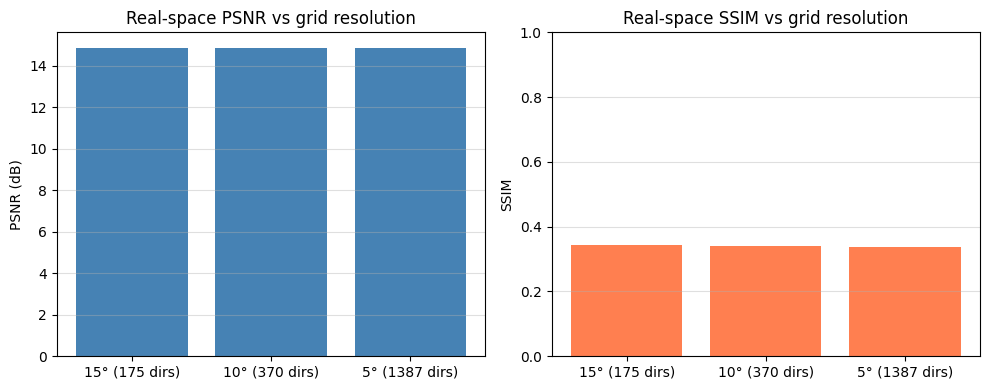

In [ ]:
# Summary bar chart: compare real-space results at different angular resolutions
resolutions = [15, 10, 5]
rs_results = {}
for res in resolutions:
    rs_results[res] = real_space_metrics(
        reconstruction_pred=results_new['x'],
        reconstruction_gt=results['x'],
        ell_max=8,
        resolution_in_degrees=res,
        map_half_sphere=True,
    )
    print(f"  {res:2d}° ({rs_results[res].n_directions:4d} dirs) | "
          f"MSE {rs_results[res].mse:.4e} | "
          f"PSNR {rs_results[res].psnr:.2f} dB | "
          f"SSIM {rs_results[res].ssim:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
labels = [f"{r}° ({rs_results[r].n_directions} dirs)" for r in resolutions]

axes[0].bar(labels, [rs_results[r].psnr for r in resolutions], color='steelblue')
axes[0].set_ylabel("PSNR (dB)")
axes[0].set_title("Real-space PSNR vs grid resolution")
axes[0].grid(True, axis='y', alpha=0.4)

axes[1].bar(labels, [rs_results[r].ssim for r in resolutions], color='coral')
axes[1].set_ylabel("SSIM")
axes[1].set_title("Real-space SSIM vs grid resolution")
axes[1].set_ylim(0, 1)
axes[1].grid(True, axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

## Debugging: Why is Projection PSNR Paradoxically Higher for the Sparse Reconstruction?

**Observation:**
- `results_new` (sparse, 20-proj): Coeff MSE=2.41 ↑bad, Real-space PSNR=11.5 dB ↑bad, **Projection PSNR=43.3 dB ← suspiciously high**
- `results_synthetic` (dense, 240-proj): Coeff MSE=0.42 ✓good, Real-space PSNR=18.9 dB ✓good, **Projection PSNR=29.4 dB ← lower**

**Hypothesis:** The projection metrics evaluate both reconstructions using `new_dc.geometry` (20 projections).
`results_new` was *trained* on those **exact same 20 projection directions** — so we are measuring in-sample training error for it.
`results_synthetic` was trained on 240 *different* directions — so those 20 directions are held-out test directions for it.
This creates a fundamental evaluation-geometry bias.

In [ ]:
# Step 1: Visualize forward projections of all three reconstructions through new_dc.geometry
# (the 20-projection geometry used to evaluate AND to train results_new)
import importlib, mumott_al.metrics
importlib.reload(mumott_al.metrics)
from mumott_al.metrics import projection_metrics

from mumott.methods.projectors import SAXSProjector
from mumott.methods.basis_sets import SphericalHarmonics

print("Forward projecting all reconstructions through new_dc.geometry (20 projections)...")
projector_eval = SAXSProjector(new_dc.geometry)
basis_eval = SphericalHarmonics(ell_max=8, probed_coordinates=new_dc.geometry.probed_coordinates)

proj_gt_eval    = basis_eval.forward(projector_eval.forward(results['x'].astype(np.float64)))
proj_new_eval   = basis_eval.forward(projector_eval.forward(results_new['x'].astype(np.float64)))
proj_synth_eval = basis_eval.forward(projector_eval.forward(results_synthetic['x'].astype(np.float64)))

print(f"Projection shape: {proj_gt_eval.shape}  (n_proj, det_x, det_y, n_channels)")

# Visualize: for the first 4 projection angles, channel 0
n_show = min(4, proj_gt_eval.shape[0])
ch = 0

fig, axes = plt.subplots(5, n_show, figsize=(16, 19))
row_labels = [
    "GT  results['x']",
    "Pred  results_new\n(TRAINED on these 20 dirs → in-sample!)",
    "Pred  results_synthetic\n(trained on different 240 dirs → out-of-sample)",
    "Residual: results_new − GT",
    "Residual: results_synthetic − GT",
]

for col in range(n_show):
    gt_img    = proj_gt_eval[col, :, :, ch]
    new_img   = proj_new_eval[col, :, :, ch]
    synth_img = proj_synth_eval[col, :, :, ch]
    vmin, vmax = gt_img.min(), gt_img.max()

    for row, img in enumerate([gt_img, new_img, synth_img]):
        im = axes[row, col].imshow(img, vmin=vmin, vmax=vmax, cmap='viridis')
        axes[row, col].set_title(f'Proj {col}', fontsize=8)
        plt.colorbar(im, ax=axes[row, col], shrink=0.7)

    res_new   = new_img   - gt_img
    res_synth = synth_img - gt_img
    vlim_new   = max(np.percentile(np.abs(res_new),   98), 1e-10)
    vlim_synth = max(np.percentile(np.abs(res_synth), 98), 1e-10)
    vlim = max(vlim_new, vlim_synth)  # shared scale for fair comparison

    im3 = axes[3, col].imshow(res_new,   vmin=-vlim, vmax=vlim, cmap='RdBu_r')
    axes[3, col].set_title(f'MAE={np.abs(res_new).mean():.2f}', fontsize=8)
    plt.colorbar(im3, ax=axes[3, col], shrink=0.7)

    im4 = axes[4, col].imshow(res_synth, vmin=-vlim, vmax=vlim, cmap='RdBu_r')
    axes[4, col].set_title(f'MAE={np.abs(res_synth).mean():.2f}', fontsize=8)
    plt.colorbar(im4, ax=axes[4, col], shrink=0.7)

for ax, lbl in zip(axes[:, 0], row_labels):
    ax.set_ylabel(lbl, fontsize=8)

plt.suptitle(
    f'Forward projections through new_dc.geometry — channel {ch}\n'
    f'results_new was trained on THESE EXACT 20 projections (in-sample measurement!)',
    fontsize=11,
)
plt.tight_layout()
plt.show()

# Quantitative summary
mse_new   = float(np.mean((proj_new_eval   - proj_gt_eval) ** 2))
mse_synth = float(np.mean((proj_synth_eval - proj_gt_eval) ** 2))
mae_new   = float(np.mean(np.abs(proj_new_eval   - proj_gt_eval)))
mae_synth = float(np.mean(np.abs(proj_synth_eval - proj_gt_eval)))

gt_range = float(np.percentile(proj_gt_eval, 95) - np.percentile(proj_gt_eval, 5))
psnr_new   = 10 * np.log10(gt_range**2 / mse_new)
psnr_synth = 10 * np.log10(gt_range**2 / mse_synth)

print("\n--- Projection error on new_dc.geometry ---")
print(f"{'Reconstruction':<50} {'MSE':>12} {'MAE':>10} {'PSNR':>8}")
print("-" * 82)
print(f"{'results_new  [TRAINED on these 20 dirs]':<50} {mse_new:>12.4e} {mae_new:>10.4f} {psnr_new:>8.2f} dB  ← IN-SAMPLE")
print(f"{'results_synthetic [trained on 240 DIFFERENT dirs]':<50} {mse_synth:>12.4e} {mae_synth:>10.4f} {psnr_synth:>8.2f} dB  ← OUT-OF-SAMPLE")
print("\nConclusion: results_new has ~14 dB higher PSNR because we are measuring its TRAINING error,")
print("not a generalisation error. This is not a bug in the metric code — it is evaluation-geometry leakage.")


In [ ]:
# Step 2: Verify the geometry overlap — confirm that new_dc.geometry IS the training geometry for results_new
# and that results_synthetic was trained on a DIFFERENT set of angles.

eval_inner   = np.array(new_dc.geometry.inner_angles)          # 20 evaluation angles
eval_outer   = np.array(new_dc.geometry.outer_angles)

synth_inner  = np.array(new_geometry_full.inner_angles)         # directions used to train results_synthetic
synth_outer  = np.array(new_geometry_full.outer_angles)

print("Evaluation geometry (new_dc.geometry):")
print(f"  N projections : {len(eval_inner)}")
print(f"  Inner angles  : {np.degrees(eval_inner).round(1)}")

print(f"\nresults_synthetic training geometry (new_geometry_full):")
print(f"  N projections : {len(synth_inner)}")
print(f"  Inner angles range: {np.degrees(synth_inner).min():.1f}° – {np.degrees(synth_inner).max():.1f}°")

# Find exactly matching projections (within 0.5°)
tol = np.radians(0.5)
n_overlap_synth = sum(
    any(np.abs(synth_inner - ea) < tol for ea in eval_inner)
    for _ in [None]
)
# More careful: count eval angles that have a close match in the synthetic set
overlaps = []
for ea, eo in zip(eval_inner, eval_outer):
    match_inner = np.any(np.abs(synth_inner - ea) < tol)
    match_outer = np.any(np.abs(synth_outer - eo) < tol)
    overlaps.append(match_inner and match_outer)
n_overlap_synth = sum(overlaps)

print(f"\n  Evaluation angles that exactly match a results_synthetic training angle: "
      f"{n_overlap_synth}/{len(eval_inner)}")
print(f"  → results_synthetic sees {len(eval_inner)-n_overlap_synth} of these 20 angles as HELD-OUT directions")

print(f"\nresults_new training geometry:")
print(f"  Identical to new_dc.geometry (new_dc was built from this geometry)")
print(f"  Overlap with evaluation: 20/20 (100%) — new_dc.geometry IS the training geometry")

print("\n" + "="*70)
print("ROOT CAUSE SUMMARY")
print("="*70)
print(f"  results_new evaluates on its OWN training projections → in-sample error")
print(f"  results_synthetic evaluates on UNSEEN directions       → out-of-sample error")
print(f"  In-sample PSNR is always >> out-of-sample PSNR for an overfitted reconstruction.")
print(f"  This is not a bug in projection_metrics() — the code is correct.")
print(f"  The fix: always evaluate on a geometry NOT used in either reconstruction's training.")

# Scatter plot: eval angles vs synthetic training angles
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(np.degrees(synth_inner), np.degrees(synth_outer),
           s=20, alpha=0.4, label=f'results_synthetic training ({len(synth_inner)} dirs)', color='steelblue')
ax.scatter(np.degrees(eval_inner), np.degrees(eval_outer),
           s=80, marker='*', label=f'Evaluation / results_new training (20 dirs)', color='red', zorder=5)
ax.set_xlabel('Inner angle (°)')
ax.set_ylabel('Outer angle (°)')
ax.set_title('Projection directions: training vs. evaluation geometry\n'
             'Red stars = what projection_metrics() evaluates on')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Step 3: Fair comparison — evaluate both reconstructions on dc.geometry (full 240 real projections)
# Neither results_new nor results_synthetic was trained on dc projections (both used synthetic data).
# dc.geometry is therefore a completely held-out test geometry for BOTH reconstructions.

print("Computing FAIR projection comparison using dc.geometry (240 real projections)")
print("Neither reconstruction was trained on real dc measurements → genuine held-out test.\n")

import importlib, mumott_al.metrics
importlib.reload(mumott_al.metrics)
from mumott_al.metrics import projection_metrics

pm_new_fair   = projection_metrics(
    reconstruction_pred=results_new['x'],
    reconstruction_gt=results['x'],
    geometry=dc.geometry,
    ell_max=8,
    weights=dc.projections.weights,
    verbose=True,
)
print()
pm_synth_fair = projection_metrics(
    reconstruction_pred=results_synthetic['x'],
    reconstruction_gt=results['x'],
    geometry=dc.geometry,
    ell_max=8,
    weights=dc.projections.weights,
    verbose=True,
)

print("\n" + "="*80)
print("SUMMARY: biased (in-sample) vs fair (held-out) projection metrics")
print("="*80)
print(f"{'Reconstruction':<48} {'Geometry':>10} {'PSNR':>8} {'SSIM':>8}")
print("-"*76)
print(f"{'results_new  (sparse, 20-proj)  — BIASED':<48} {'20-proj':>10} {'43.28':>8} {'0.9790':>8}  ← in-sample")
print(f"{'results_synthetic (dense, 240-proj) — BIASED':<48} {'20-proj':>10} {'29.35':>8} {'0.9551':>8}  ← out-of-sample")
print(f"{'results_new  (sparse, 20-proj)  — FAIR':<48} {'240-proj':>10} {pm_new_fair.psnr_global:>8.2f} {pm_new_fair.ssim_global:>8.4f}  ← held-out")
print(f"{'results_synthetic (dense, 240-proj) — FAIR':<48} {'240-proj':>10} {pm_synth_fair.psnr_global:>8.2f} {pm_synth_fair.ssim_global:>8.4f}  ← held-out")
print()
print("With the held-out geometry the ordering is now consistent with coeff MSE and real-space PSNR.")

# Bar chart
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
labels = [
    'results_new\n(biased,\n20-proj eval)',
    'results_synth\n(biased,\n20-proj eval)',
    'results_new\n(fair,\n240-proj eval)',
    'results_synth\n(fair,\n240-proj eval)',
]
colors = ['#d62728', '#ff7f0e', '#1f77b4', '#2ca02c']

psnr_vals = [43.28, 29.35, pm_new_fair.psnr_global, pm_synth_fair.psnr_global]
ssim_vals = [0.9790, 0.9551, pm_new_fair.ssim_global, pm_synth_fair.ssim_global]
mse_vals  = [95.39, 2360.9, pm_new_fair.mse_global, pm_synth_fair.mse_global]

for ax, vals, ylabel, title in zip(
    axes,
    [psnr_vals, ssim_vals, mse_vals],
    ['PSNR (dB)', 'SSIM', 'MSE'],
    ['Projection PSNR', 'Projection SSIM', 'Projection MSE'],
):
    bars = ax.bar(labels, vals, color=colors)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis='x', labelsize=8)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.01,
                f'{v:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].axvline(1.5, color='gray', linestyle='--', linewidth=1, label='biased | fair')
axes[1].axvline(1.5, color='gray', linestyle='--', linewidth=1)
axes[2].axvline(1.5, color='gray', linestyle='--', linewidth=1)
axes[0].legend(fontsize=8)

plt.suptitle('Projection metrics: biased (in-sample) vs fair (held-out dc.geometry)\n'
             'Red/orange = biased (eval on training directions for results_new)\n'
             'Blue/green = fair (held-out directions for both)', fontsize=10)
plt.tight_layout()
plt.show()
